## Load the Libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_columns', 500)

# For plotting
from itertools import cycle
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
tweets = pd.read_csv("tweets.csv")

## Basic Preprocessing

In [4]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩


In [5]:
tweets.shape

(1178454, 5)

In [6]:
print(tweets['tweet_text'][0])

Wordle 210 4/6

⬛⬛🟨🟨⬛
🟩⬛⬛⬛⬛
🟩🟩🟨⬛⬛
🟩🟩🟩🟩🟩


In [7]:
def process_tweets(tweets):
    tweets['tweet_datetime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['wordle_id'] = tweets['wordle_id'].astype('int')
    return tweets

In [8]:
tweets = process_tweets(tweets)

## Analysis

### Tweets per day

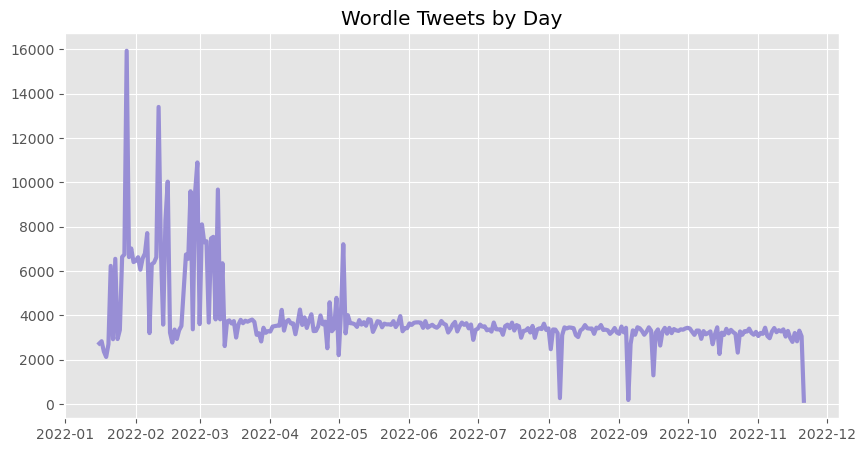

In [11]:
tweets['tweet_date'].value_counts().plot(figsize = (10,5), title = 'Wordle Tweets by Day', color = color_pal[2], lw=3)
plt.show()

### Number of Attempts Analysis

In [14]:
tweets.groupby(['wordle_id'])['n_attempts'].value_counts().unstack().style.background_gradient(axis = 1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
210,222,897,1064,489,165
211,196,903,1016,564,215
212,191,787,820,413,188
213,51,260,630,697,481
214,383,1012,823,363,122
215,246,877,1017,579,224
216,461,1952,2078,1199,415
217,102,566,1031,843,418
218,170,1009,1384,730,187


We notice that most wordles took around 4 attempts to solve! However, we notice a slight change in trend around wordle 233, with many more people needing 5 attempts to solve the wordles. Could that be that the wordles started becoming harder? 

In [20]:
tweets.groupby(['wordle_id']).agg({'tweet_date': [max, min]}).loc[233]

tweet_date  max    2022-02-08
            min    2022-02-07
Name: 233, dtype: object

We notice that Wordle 233 appeared in February 2022 which was also when NYTimes took over Wordle. By a quick Internet search, there were many rumors that NYTimes had made the game harder at the time.

### How many attempts does it usually take to solve?

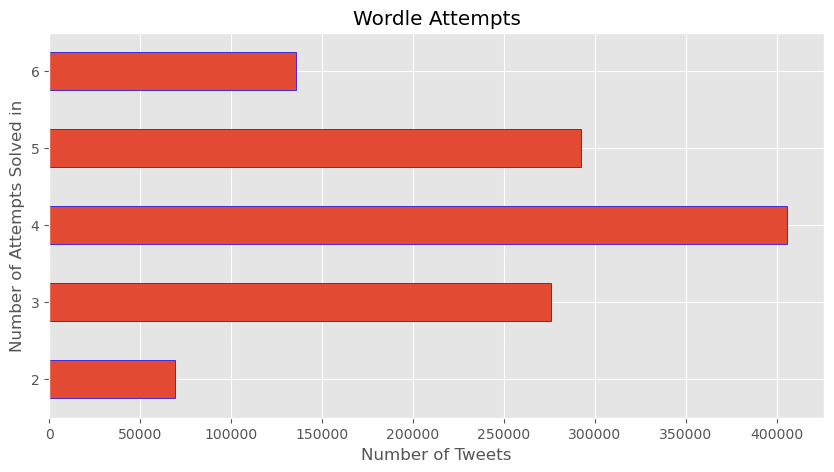

In [24]:
ax = tweets['n_attempts'].value_counts().sort_index() \
    .plot(figsize=(10, 5),
          kind='barh',
          title='Wordle Attempts',
          edgecolor='blue')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved in')
plt.show()

### Tweet Text Parsing

In [25]:
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [26]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        # Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
        # Count the number of correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'],
                       f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

In [27]:
tweets = parse_tweet_text(tweets)

In [28]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_datetime,n_attempts,has_guess1,guess1,guess1_incorrect,guess1_wrong_spot,guess1_correct,final_guess,has_guess2,guess2,guess2_incorrect,guess2_wrong_spot,guess2_correct,has_guess3,guess3,guess3_incorrect,guess3_wrong_spot,guess3_correct,has_guess4,guess4,guess4_incorrect,guess4_wrong_spot,guess4_correct,has_guess5,guess5,guess5_incorrect,guess5_wrong_spot,guess5_correct,has_guess6,guess6,guess6_incorrect,guess6_wrong_spot,guess6_correct
0,210,1482553374591660037,2022-01-16,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:43+00:00,4,True,⬛⬛🟨🟨⬛,3,2,0,NaN,True,🟩⬛⬛⬛⬛,4.0,0.0,1.0,True,🟩🟩🟨⬛⬛,2.0,1.0,2.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
1,210,1482553387937898499,2022-01-16,cruisecoup,Wordle 210 4/6\n\n⬛⬛⬛⬛⬛\n🟩🟩🟨🟨⬛\n🟩🟩⬛🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16 03:20:46+00:00,4,True,⬛⬛⬛⬛⬛,5,0,0,NaN,True,🟩🟩🟨🟨⬛,1.0,2.0,2.0,True,🟩🟩⬛🟩🟨,1.0,1.0,3.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,210,1482553422276698113,2022-01-16,DestroVega,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n⬛🟩⬛🟨⬛\n⬛🟩⬛🟨⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:55+00:00,4,True,⬛⬛⬛🟨⬛,4,1,0,NaN,True,⬛🟩⬛🟨⬛,3.0,1.0,1.0,True,⬛🟩⬛🟨⬛,3.0,1.0,1.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
3,210,1482553436910628866,2022-01-16,brenmardash,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟨🟨⬛⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:58+00:00,3,True,⬛⬛🟨⬛⬛,4,1,0,NaN,True,🟨🟨⬛⬛⬛,3.0,2.0,0.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,210,1482553445726908420,2022-01-16,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:21:00+00:00,3,True,⬛⬛🟨⬛⬛,4,1,0,NaN,True,🟩🟩🟩⬛⬛,2.0,0.0,3.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


In [29]:
## Capture comments after the solution

tweets['additional_text'] = tweets.loc[~tweets['tweet_text'].str.split('\n').str[-1].str.contains('🟩')] \
    ['tweet_text'].str.split('\n').str[-1]

In [31]:
tweets.additional_text.unique()

array([nan, 'Got lucky lol',
       'Oh boy….I just played for the first time. I can definitely see myself developing… https://t.co/9hnH8NzFKb',
       ..., 'I hate this more than if I just didn’t get it at all.',
       'https://t.co/pV7m3NeDkz ',
       'I play #wordle better when the \u2066@Bengals\u2069 win! #bengals #cincinnati #whodey 🤓🧡🖤😎'],
      dtype=object)

### Results by Attempt analysis

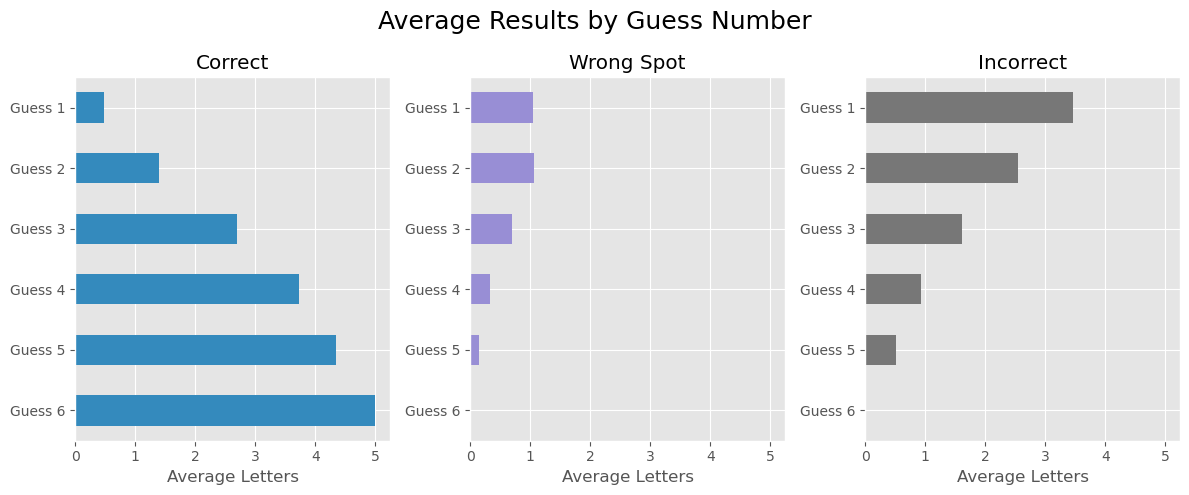

In [33]:
fig, axs = plt.subplots(1,3, figsize = (12,5), sharex= True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i],
              color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

In [36]:
tweets.wordle_id.max()

519

### Letter Analysis

In [39]:
### Read the file that contains the answers to each wordle

answers = pd.read_csv("answers.csv", header = None)

In [44]:
answers = answers.reset_index()
answers.columns = ['index', 'solutions']

In [55]:
## Preprocess the file so we only keep the wordle id and the solution
answers['id'] = answers['solutions'].str.extract(r'#(\d+)')
answers['Text'] = answers['solutions'].str.split('-').str[-1].str.strip()

In [68]:
## Creation of dictionary with solutions
answers_dict = dict(zip(answers['id'].astype(int), answers['Text']))

In [69]:
answers_dict

{210: 'PANIC',
 211: 'SOLAR',
 212: 'SHIRE',
 213: 'PROXY',
 214: 'POINT',
 215: 'ROBOT',
 216: 'PRICK',
 217: 'WINCE',
 218: 'CRIMP',
 219: 'KNOLL',
 220: 'SUGAR',
 221: 'WHACK',
 222: 'MOUNT',
 223: 'PERKY',
 224: 'COULD',
 225: 'WRUNG',
 226: 'LIGHT',
 227: 'THOSE',
 228: 'MOIST',
 229: 'SHARD',
 230: 'PLEAT',
 231: 'ALOFT',
 232: 'SKILL',
 233: 'ELDER',
 234: 'FRAME',
 235: 'HUMOR',
 236: 'PAUSE',
 237: 'ULCER',
 238: 'ULTRA',
 239: 'ROBIN',
 240: 'CYNIC',
 241: 'AROMA',
 242: 'CAULK',
 243: 'SHAKE',
 244: 'DODGE',
 245: 'SWILL',
 246: 'TACIT',
 247: 'OTHER',
 248: 'THORN',
 249: 'TROVE',
 250: 'BLOKE',
 251: 'VIVID',
 252: 'SPILL',
 253: 'CHANT',
 254: 'CHOKE',
 255: 'RUPEE',
 256: 'NASTY',
 257: 'MOURN',
 258: 'AHEAD',
 259: 'BRINE',
 260: 'CLOTH',
 261: 'HOARD',
 262: 'SWEET',
 263: 'MONTH',
 264: 'LAPSE',
 265: 'WATCH',
 266: 'TODAY',
 267: 'FOCUS',
 268: 'SMELT',
 269: 'TEASE',
 270: 'CATER',
 271: 'MOVIE',
 272: 'SAUTE',
 273: 'ALLOW',
 274: 'RENEW',
 275: 'THEIR',
 276: 'SLO

In [70]:
## Map solutions to the original dataframe
tweets['answer'] = tweets['wordle_id'].map(answers_dict)

In [71]:
first_guess_correct = []
for i, d in tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

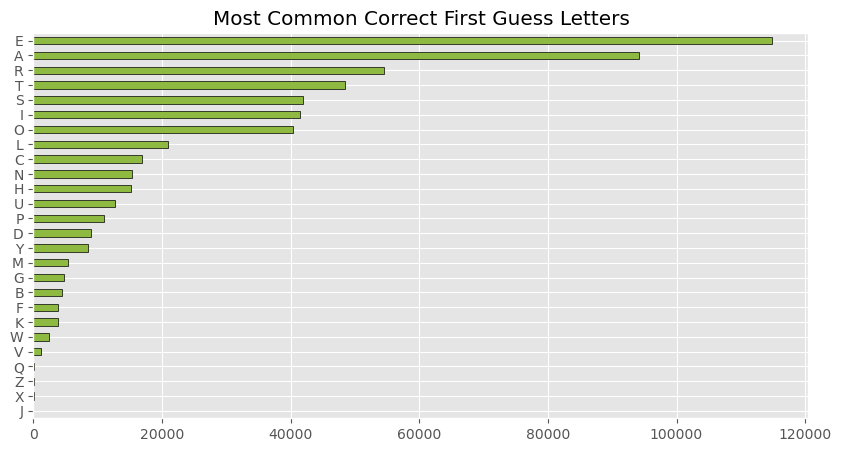

In [72]:
pd.Series(first_guess_correct).value_counts(ascending=True).plot(kind='barh', figsize=(10, 5),
         title='Most Common Correct First Guess Letters',
         edgecolor='black', color=color_pal[5])
plt.show()

Most common letter to be guessed correctly in the first guess is 'E'